# Toy neural network example

We train a neural network giving of u in <0,1> a point (x,y) with coordinates 
$x = cos(2\pi u)$
$y = sin(2\pi u)$
that is, a point on a unit circle. The network will work as a random "transformer", transforming a random u in <0,1> to a random point on a unit circle. 

# Tasks:
### 1. Study the code.
There are several things that can be new:
- numpy arrays: notice how we can operate on arrays - square them, take a sine or cosine, reshape them
- pandas dataframes: notice how we can pack several arrays into a data table - a pandas DataFrame.
- matplotlib plots: notice how simply we plot things.

### 2. Study the neural network.
- Training data. To train a neural network, we have to have a proper sample of training data. In this case, it is very simple to generate them. See what happens when you use a smaller or larger training sample.
- Hyperparameters. We have some freedom in selecting how the network looks (sizes of hidden layers) and how we train it. Look into scikit-learn documentation (google "scikit learn MLPRegressor") and experiment with various combinations of hyperparameters. Optimize training data size and hyperparameters to achieve best precision.
Rules for hidden layers: 
(i) In theory, a neural network with a single layer can represent any mapping between inputs and outputs (if sufficiently large). 
(ii) If the problem is strongly non-linear, then a two-layer network can be easier to train. 
(iii) More than two hidden layers are usually unnecessary.

### 3. Investigate the problem.
We need a surprisingly large network and a lot of training data to make the example work.
On the other hand, the training is fairly fast. 

A. Create a network that will produce density proportional to $u(1-u)$ on the unit circle (rather than uniform)

B. Create a network that will produce uniform density on an ellipse.

C. Our network has a single input, u. Try to add some orthogonal polynomials (Legendre or Chebyshev) as additional inputs and examine how such networks train.

## 0. Includes

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import uniform
from scipy.special import legendre
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy.polynomial as npp

In [2]:
# testovaci bunka
u = uniform.rvs(0,1) 
x = np.cos(2*np.pi*u)
y = np.sin(2*np.pi*u)
n_polynomials=range(0,10)
polynomials=[0]*len(n_polynomials)
pickone_matrix=np.identity(len(n_polynomials))
for i in n_polynomials:
    polynomials[i]=npp.legendre.legval(u,pickone_matrix[i])
print(polynomials)
data_array=np.array(polynomials+[x]+[y])
print(data_array)
df=pd.DataFrame(data_array.reshape(-1, len(data_array)),columns=['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9','x','y'])

[1.0, 0.31613274493916255, -0.3500901313658456, -0.39521342030076961, 0.043922767580548971, 0.34116450138563059, 0.16112868923074941, -0.19782747081703203, -0.25824961815270647, 0.021635559468051069]
[ 1.          0.31613274 -0.35009013 -0.39521342  0.04392277  0.3411645
  0.16112869 -0.19782747 -0.25824962  0.02163556 -0.40366966  0.91490481]


## 1. Generate data

In [3]:
def legendre_expand(X, degree = None, target_column = None):
    n_terms = degree-1
    X_new = np.empty((X.shape[0], X.shape[1] + n_terms))
    X_new[:,:X.shape[1]] = X
    x = X[:,target_column]
    column = X.shape[1]
    for i in range(2, degree+1):
        X_new[:,column] = legendre(i)(x).ravel()
        column += 1
    return X_new


In [60]:
def make_circle_data(n_samples = 100):
    """Creates pandas dataframe with columns u, x, y, such that u ~ U[0,1], x = cos(2*pi*u), y = sin(2*pi*u)."""
    u = uniform.rvs(0,1,n_samples)
    x = np.cos(2*np.pi*u)
    y = np.sin(2*np.pi*u)
    n_terms = 10
    pickone_matrix=np.identity(n_terms)
    polynomials = np.ndarray((len(u), 2+n_terms))
    for i in range(n_terms):
        polynomials[:,i]=npp.legendre.legval(2*(u-0.5),pickone_matrix[i])
    polynomials[:,n_terms:(n_terms+1)] = x[:,np.newaxis]
    polynomials[:,(n_terms+1):(n_terms+2)] = y[:,np.newaxis]
    colnames = ['p' + str(i) for i in range(n_terms)] + ['x', 'y']
    return pd.DataFrame(polynomials,columns=colnames)


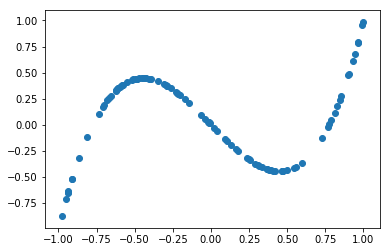

In [61]:
sk = make_circle_data(n_samples = 100)
plt.scatter(sk.p1, sk.p3)

## 2. Train a network regressor

In [62]:
def train_network(data, test_fraction = 0.1):
    """Returns a trained network object"""
    input_cols = ['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9']
    output_cols = ['x','y']
    n_rows = len(data)
    n_test = int(n_rows * test_fraction)
    n_train = n_rows - n_test
    X_train = data[input_cols].values[:n_train]
    X_test = data[input_cols].values[n_train:]
    Y_train = data[output_cols].values[:n_train]
    Y_test = data[output_cols].values[n_train:]
    fitter = MLPRegressor(
                hidden_layer_sizes = (60,60),
                activation = 'relu',
                tol = 1.0e-7,
                alpha = 1.0e-5,
                verbose = False
            )
    fitter.fit(X_train, Y_train)
    print('Fit done. Score: {0}'.format(fitter.score(X_test, Y_test)))
    Y_pred = fitter.predict(X_test)
    rmse = np.sqrt(np.sum((Y_pred - Y_test)**2, axis = 0)/n_test)
    print('RMS error: x {0}, y {1}'.format(rmse[0], rmse[1]))
    return fitter

## 3. Run and plot results

In [73]:
# Generate samples
samples = make_circle_data(2000)
samples.head()
# Train the network
fitter = train_network(samples)

Fit done. Score: 0.9999887365024962
RMS error: x 0.002713436249563742, y 0.0019580713310014524


### Results: x vs. y

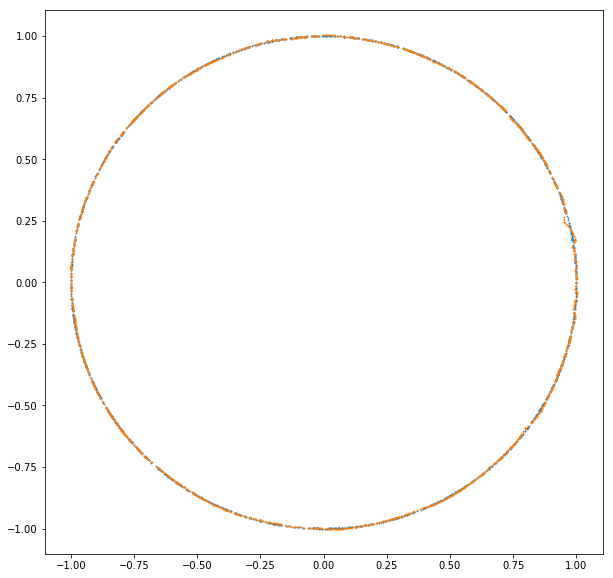

In [74]:
input_cols = ['p0','p1','p2','p3','p4','p5','p6','p7','p8','p9']
y_pred = fitter.predict(samples[input_cols].values)
fig = plt.figure(figsize = (10,10))
plt.scatter(samples.x,samples.y, s = 0.5)
plt.scatter(y_pred[:,0], y_pred[:,1], s = 0.5)
plt.savefig('../pictures/circle_generator_2d_legendre.png')

### Results: x, y vs. u

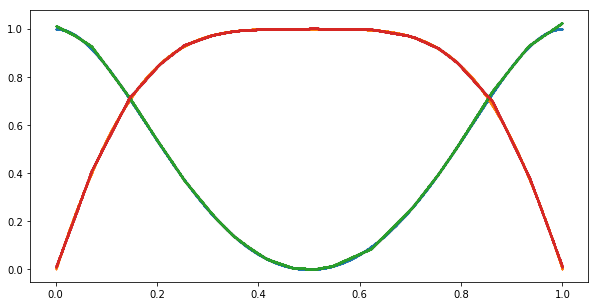

In [6]:
fig = plt.figure(figsize = (10,5))
plt.scatter(samples.u, samples.x, s = 0.2)
plt.scatter(samples.u, samples.y, s = 0.2)
plt.scatter(samples.u, y_pred[:,0], s = 0.2)
plt.scatter(samples.u, y_pred[:,1], s = 0.2)
plt.savefig('../pictures/circle_generator_1d.png')
